In [1]:
from IPython.display import Code
import inspect

import sys
# Own code
sys.path.insert(0, './') # add local sources

import internal.ContourFitting as ContourFitting

# TL;DR
This blog builds on top of a [prior blog post](https://schwarzstift.github.io/blog/gbp/2022/10/04/gaussian-belief-propagation.html) of mine, where I explained a Gaussian Belief Propagation (GBP) implementation.
Here I want to replicate the Contour Fitting application presented in [this blog](https://gaussianbp.github.io/).
Despite the fact, that it is well described in the mentioned blog article, I like to see the formulars and code side by side.

So that's what this blog post is about: 
1. Reimplementing the Contour Fitting application
2. Set it side by side with the equations from the mentioned blog post.

If that's of interest to you, go ahead an read further.
The complete sources can be found [here](https://github.com/Schwarzstift/blog/tree/gh-pages/src/GaussianBeliefPropagation/internal)

# Problem description

Here we want to estimate the contour from multiple measurements.
For this, we have a fixed number of variable nodes, which represents a part of the estimated contour.

The Factor Graph proposed by [this blog](https://gaussianbp.github.io/) looks something like this:

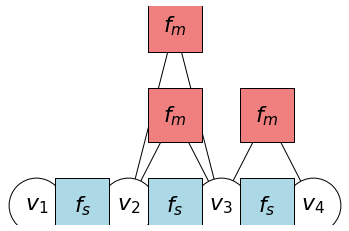

In [2]:
import pylab
import networkx as nx

pylab.rcParams["figure.figsize"] = (10,6)
pylab.axes(frameon = 0)

pos = {0: (1, 0), 1: (2, 0), 2: (3, 0), 3: (4,0), 4:(5,0), 5:(6,0), 6:(7,0), 7:(4,1),8:(4,2), 9:(6,1)}
edges = [(0,1), (1,2), (2,3), (3,4),(4,5),(5,6),(7,2),(7,4),(8,2),(8,4),(9,4),(9,6)]
G = nx.Graph(edges, with_labels=False)
optionsFactorMeasurement = {
    "node_size": 3000,
    "node_color": "lightcoral",
    "edgecolors": "black",
    "linewidths": 1,
    "node_shape": 's',
}
optionsFactorSmooth = {
    "node_size": 3000,
    "node_color": "lightblue",
    "edgecolors": "black",
    "linewidths": 1,
    "node_shape": 's',
}
optionsVariable = {
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    #"node_shape": 'o'
}
nx.draw_networkx_nodes(G, pos, nodelist=[0,2,4,6], **optionsVariable)
nx.draw_networkx_nodes(G, pos, nodelist=[1,3,5], **optionsFactorSmooth)
nx.draw_networkx_nodes(G, pos, nodelist=[7,8,9], **optionsFactorMeasurement)
# some math labels
labels = {}
labels[0] = r"$v_1$"
labels[1] = r"$f_s$"
labels[2] = r"$v_2$"
labels[3] = r"$f_s$"
labels[4] = r"$v_3$"
labels[5] = r"$f_s$"
labels[6] = r"$v_4$"
labels[7] = r"$f_m$"
labels[8] = r"$f_m$"
labels[9] = r"$f_m$"
nx.draw_networkx_labels(G, pos, labels, font_size=22, font_color="black")
# edges
#nx.draw_networkx_edges(G, pos, arrowstyle="->", arrows=True)
nx.draw_networkx_edges(G, pos, edge_color='k', arrowsize= 20, node_size=3000)
pylab.show()

Here the x position of the variable nodes $$v_n$$ are fixed. 
In my example, they are uniformly distributed in an interval from $$[0,1]$$.
This reduces the complexity of this problem to only one dimension.
In other words, whats left is to estimate the correct height of each variable node.

But first things first, let's create the variable nodes using this function: 

In [3]:
lines = inspect.getsource(ContourFitting.generate_variable_nodes)
Code(lines, language="python")

def generate_variable_nodes(num_variable_nodes: int, dims) -> List[VariableNode]:
    """
    Generates variable nodes with an x pos uniform over the interval [0,1]
    :param num_variable_nodes: number of nodes to generate
    :param dims: dimensions for each node
    :return: list containing all generated nodes
    """
    nodes = []
    for i in range(num_variable_nodes):
        node = VariableNode(dims)
        node.x_pos = i / (num_variable_nodes - 1)
        nodes.append(node)
    return nodes

Having our variable nodes, we need our measurements.
Let's start with a simple step. which is sampled from using this function:

In [4]:
lines = inspect.getsource(ContourFitting.generate_measurement_step)
Code(lines, language="python")

def generate_measurement_step():
    """
    Samples measuremetns from a step function
    :return: measurement (x,y)
    """
    height_measurement = np.random.random() * 0.
    x_pos = np.random.random()
    if x_pos < 0.5:
        height_measurement += 0.5
    return x_pos, height_measurement

With this sampling function, we can now generate actual measurements and the according measurement factors (depicted red in the image above).
The general idea is that the measurement is represented as a factor.
This factor is connected to two variable nodes, which are left and right from the measurement.

Apart from the measurement itself, the measurement factor needs also the measurement function and the corresponding jaccobian.
both are functions, which are described in more detail below.

In [5]:
lines = inspect.getsource(ContourFitting.generate_measurement_factors)
Code(lines, language="python")

def generate_measurement_factors(v_nodes: List[VariableNode], measurement_generator,
                                 num_measurements: int, meas_noise, use_huber: bool) -> Tuple[
    List[FactorNode], List[np.ndarray]]:
    """
    Generates the measurement factors and measurements (one factor for each measurement)
    :param v_nodes: all variable nodes
    :param measurement_generator:  measurement generating function
    :param num_measurements: number of measurements to generate
    :param meas_noise: measurement noise
    :return: list of all measurement factors
    """
    f_nodes = []
    gen_meas = []
    for i in range(num_measurements):
        measurement_x_pos, height_measurement = measurement_generator()
        idx_var_node = int(measurement_x_pos * (len(v_nodes) - 1))

        adj_vars = [v_nodes[idx_var_node], v_nodes[idx_var_node + 1]]
        meas_fn = measurement_fn
        jac_fn = measurement_fn_jac
        f_nodes.append(FactorNode(adj_vars, meas_fn, meas_noise, height_measurement, jac_fn, use_huber,
                                  [v_nodes[idx_var_node].x_pos, v_nodes[idx_var_node + 1].x_pos, measurement_x_pos]))
        gen_meas.append(np.array([measurement_x_pos, height_measurement]))

    return f_nodes, gen_meas

Below is the measurement function and it's jaccobian defined.

The basic idea is to split the measurement between the two adjacent nodes according to the x position of the measurement and the nodes.

In [6]:
lines = inspect.getsource(ContourFitting.measurement_fn)
Code(lines, language="python")

def measurement_fn(means: List[np.ndarray], x_pos_i: float, x_pos_j: float, x_pos_of_measurement: float) -> np.ndarray:
    """
    Simple measurement function which divides the measurement between two factors
    :param means: current height estimate of the nodes
    :param x_pos_i: x position of the left variable
    :param x_pos_j: x position of the right variable
    :param x_pos_of_measurement: x position of the measurement
    :return: measurement
    """
    x_m = x_pos_of_measurement
    x_i = x_pos_i
    x_j = x_pos_j
    y_i = means[0]
    y_j = means[1]
    lam = (x_m - x_i) / (x_j - x_i)
    return (1 - lam) * y_i + lam * y_j

In [7]:
lines = inspect.getsource(ContourFitting.measurement_fn_jac)
Code(lines, language="python")

def measurement_fn_jac(means: List[np.ndarray], x_pos_i: float, x_pos_j: float,
                       x_pos_of_measurement: float) -> np.ndarray:
    """
    Jacobian of the measurement function above
    :param means: current height estimate of the nodes
    :param x_pos_i: x position of the left variable
    :param x_pos_j: x position of the right variable
    :param x_pos_of_measurement: x position of the measurement
    :return: Jacobian
    """
    x_m = x_pos_of_measurement
    x_i = x_pos_i
    x_j = x_pos_j
    gamma = (x_m - x_i) / (x_j - x_i)
    return np.array([[(1 - gamma), gamma]])

Next to the measurement factors, we need smoothing factors as well, which are depicted blue in the image above.
These smoothing factors - as the name implies - tries to smooth the surface of the resulting contour.

This time there is no direct measurement, which is why I set it to 0.
The measurement function now calculates the difference between the y-values, which is basically to be minimized.

In [8]:
lines = inspect.getsource(ContourFitting.generate_smoothing_factors)
Code(lines, language="python")

def generate_smoothing_factors(v_nodes: List[VariableNode], meas_noise, use_huber: bool) -> List[FactorNode]:
    """
    Generate factor nodes with the above defined smoothing measurement function
    :param v_nodes: all variable nodes
    :param meas_noise: measurement noise
    :return: list of all smoothing factor nodes
    """
    f_nodes = []
    for i in range(len(v_nodes) - 1):
        adj_vars = [v_nodes[i], v_nodes[i + 1]]
        meas_fn = smoothing
        measurement = 0.
        jac_fn = smoothing_jac
        f_nodes.append(FactorNode(adj_vars, meas_fn, meas_noise, measurement, jac_fn, use_huber, []))
    return f_nodes

In [9]:
lines = inspect.getsource(ContourFitting.smoothing)
Code(lines, language="python")

def smoothing(means: List[np.ndarray]) -> np.ndarray:
    """
    Measurement function of the smoothing factor node
    Simple smoothing function, forcing the nodes to hold similar height values
    :param means: height estimates for each adjacent nodes (to the factor
    """
    return means[0] - means[1]

In [10]:
lines = inspect.getsource(ContourFitting.smoothing_jac)
Code(lines, language="python")

def smoothing_jac(linearization_point: List[np.ndarray]) -> np.ndarray:
    """
    Jacobian of the smoothing function
    :param linearization_point: point of evaluation (not used as linear)
    """
    return np.array([[1, -1]])

Lastly, we need to fit everything together in a little "main" function as shown below:

In [11]:
import numpy as np
lines = inspect.getsource(ContourFitting.main)
Code(lines, language="python")


def main():
    use_huber = True
    num_var = 20
    num_measurements = 10
    noise = 0.01
    meas_noise = np.array([[noise]])
    smooth_noise = np.array([[noise]])
    variable_nodes = generate_variable_nodes(num_var, 1)
    factor_nodes, measurements = generate_measurement_factors(variable_nodes, generate_measurement_step,
                                                              num_measurements, meas_noise, use_huber)
    factor_nodes.extend(generate_smoothing_factors(variable_nodes, smooth_noise, use_huber))

    factor_graph = FactorGraph(variable_nodes, factor_nodes)

    num_iters = 30
    viz = ContourFittingViz(variable_nodes, measurements, num_iters)

    for iter in range(num_iters):
        print("iteration: " + str(iter))
        factor_graph.synchronous_iteration()
        viz.add_iteration(variable_nodes)

    viz.render()

Here ContourFittingViz is just a little util class to plot the results.
An example can be seen below, which is also the endresult of this blog entry.
![alt text](LineFitting.png "Title")